<a href="https://colab.research.google.com/github/wilberquito/AMLProject/blob/main/Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resnet50

In [1]:
import zipfile
from pathlib import Path
import torch
import matplotlib.pyplot as plt

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [3]:
if IN_COLAB:
    ! pip install torchvision
    ! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    !rm -rf data
    data_path = Path('/content/drive/MyDrive/AML/dataset_CIFAR10.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall("data")

    !rm -rf modular
    data_path = Path('/content/drive/MyDrive/AML/modular.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall(".")

    !rm -rf trained
    !cp -r /content/drive/MyDrive/AML/trained/ ./trained

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Show device available

In [ ]:
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

## Show model arquitecture

In [5]:
from torchinfo import summary
import modular.models as models
from prettytable import PrettyTable

In [6]:
amlresnet50 = models.AMLResnet50(out_dim=10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [8]:
batch_size = 16
img_size = 232
summary(model=amlresnet50, 
        input_size=(32, 3, img_size, img_size),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
AMLResnet50 (AMLResnet50)                     [32, 3, 232, 232]    [32, 10]             --                   Partial
├─ResNet (net)                                [32, 3, 232, 232]    [32, 2048]           --                   False
│    └─Conv2d (conv1)                         [32, 3, 232, 232]    [32, 64, 116, 116]   (9,408)              False
│    └─BatchNorm2d (bn1)                      [32, 64, 116, 116]   [32, 64, 116, 116]   (128)                False
│    └─ReLU (relu)                            [32, 64, 116, 116]   [32, 64, 116, 116]   --                   --
│    └─MaxPool2d (maxpool)                    [32, 64, 116, 116]   [32, 64, 58, 58]     --                   --
│    └─Sequential (layer1)                    [32, 64, 58, 58]     [32, 256, 58, 58]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 58, 58]     [32, 256, 58,

In [10]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
_ = count_parameters(amlresnet50)

+-------------+------------+
|   Modules   | Parameters |
+-------------+------------+
| fc.0.weight |    2048    |
|  fc.0.bias  |    2048    |
| fc.2.weight |  1048576   |
|  fc.2.bias  |    512     |
| fc.4.weight |    512     |
|  fc.4.bias  |    512     |
| fc.6.weight |    5120    |
|  fc.6.bias  |     10     |
+-------------+------------+
Total Trainable Params: 1059338


## Fine tunning

In [1]:
import torch
import modular.datasets as datasets
import modular.models as models 
from pathlib import Path
from modular.engine import train
import torchvision.transforms as transforms
from modular.utils import set_seeds

set_seeds(seed=42)

# Model
amlresnet50 = models.AMLResnet50(out_dim=10)
# Let base train
amlresnet50.unfreeze_base()

train_transforms, validate_transforms = amlresnet50.transforms, amlresnet50.transforms

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(),
])

train_transforms = transforms.Compose([augmentation, train_transforms])

# Optimizer
lr = 0.001
optimizer = torch.optim.Adam(params=amlresnet50.parameters(),
                             lr=lr)

# Criterion
criterion = torch.nn.CrossEntropyLoss()

# Number of epochs to train the model
epochs = 3

# Default device to train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Where the model is saved
save_as = Path('finetune.amlresnet50.pth')

# Mini batch
batch_size=150

train_dataloader = datasets.get_dataloader(folder_root='data/train',
                                           transformer=train_transforms,
                                           batch_size=batch_size,
                                           suffle=True)
validate_dataloader = datasets.get_dataloader(folder_root='data/validation',
                                           transformer=validate_transforms,
                                           batch_size=batch_size,
                                           suffle=False)

In [ ]:
results = train(model=amlresnet50,
                train_dataloader=train_dataloader,
                test_dataloader=validate_dataloader,
                optimizer=optimizer,
                criterion=criterion,
                epochs=epochs,
                device=device,
                save_as=save_as)

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 1.0764 | train_acc: 0.6258 | test_loss: 0.7779 | test_acc: 0.7379


0it [00:00, ?it/s]

In [ ]:
if IN_COLAB:
  from google.colab import files
  files.download('finetune.amlresnet50.pth')

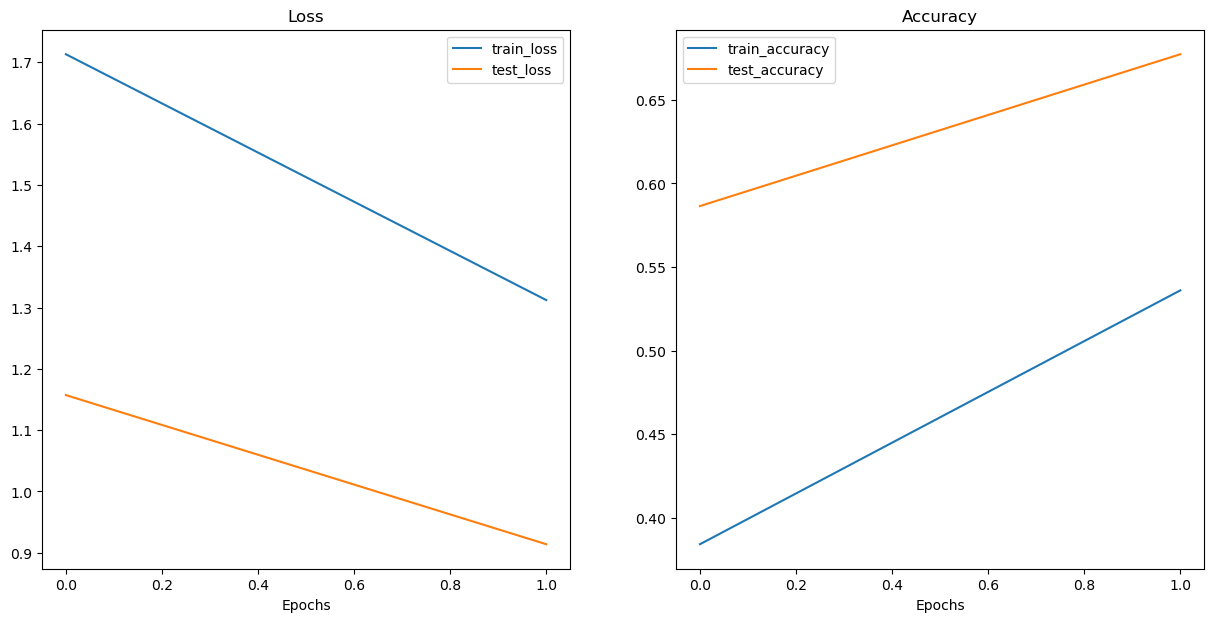

In [ ]:
from modular.utils import plot_loss_curves
plot_loss_curves(results)

## Training find tunning AMLResnet50

In [ ]:
import torch
from pathlib import Path

saved_data = torch.load(Path('trained/finetune.amlresnet50.pth'))
saved_data.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc', 'epoch', 'optimizer', 'model'])

In [ ]:
import torch
import modular.datasets as datasets
import modular.models as models 
from pathlib import Path
from modular.engine import train
import torchvision.transforms as transforms
from modular.utils import set_seeds

set_seeds(seed=42)

# Mode
amlresnet50 = models.AMLResnet50(out_dim=10)
# Recover state dict
state_dict = saved_data['model']
# Load saved state dict into the model
amlresnet50.load_state_dict(state_dict)
# Freeze base
amlresnet50.freeze_base()

train_transforms, validate_transforms = amlresnet50.transforms, amlresnet101.transforms

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(),
])

train_transforms = transforms.Compose([augmentation, train_transforms])

# Optimizer
lr = 0.001
optimizer = torch.optim.Adam(params=amlresnet50.parameters(),
                             lr=lr)

# Criterion
criterion = torch.nn.CrossEntropyLoss()

# Number of epochs to train the model
epochs = 10

# Default device to train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Where the model is saved
save_as = Path('trained/amlresnet50.pth')

# Mini batch
batch_size=125

train_dataloader = datasets.get_dataloader(folder_root='data/train',
                                           transformer=train_transforms,
                                           batch_size=batch_size,
                                           suffle=True)
validate_dataloader = datasets.get_dataloader(folder_root='data/validation',
                                           transformer=validate_transforms,
                                           batch_size=batch_size,
                                           suffle=False)

In [ ]:
results = train(model=amlresnet50,
                train_dataloader=train_dataloader,
                test_dataloader=validate_dataloader,
                optimizer=optimizer,
                criterion=criterion,
                epochs=epochs,
                device=device,
                save_as=save_as)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:03,  3.91s/it]
2it [00:05,  2.33s/it]
3it [00:06,  1.82s/it]
4it [00:07,  1.58s/it]
5it [00:08,  1.45s/it]
6it [00:09,  1.36s/it]
7it [00:11,  1.34s/it]
8it [00:12,  1.30s/it]
9it [00:13,  1.27s/it]
10it [00:14,  1.25s/it]
11it [00:16,  1.24s/it]
12it [00:17,  1.23s/it]
13it [00:18,  1.22s/it]
14it [00:19,  1.22s/it]
15it [00:20,  1.22s/it]
16it [00:22,  1.22s/it]
17it [00:23,  1.22s/it]
18it [00:24,  1.22s/it]
19it [00:25,  1.22s/it]
20it [00:27,  1.22s/it]
21it [00:28,  1.22s/it]
22it [00:29,  1.21s/it]
23it [00:30,  1.22s/it]
24it [00:31,  1.22s/it]
25it [00:33,  1.22s/it]
26it [00:34,  1.21s/it]
27it [00:35,  1.22s/it]
28it [00:36,  1.22s/it]
29it [00:37,  1.22s/it]
30it [00:39,  1.22s/it]
31it [00:40,  1.22s/it]
32it [00:41,  1.21s/it]
33it [00:42,  1.22s/it]
34it [00:44,  1.21s/it]
35it [00:45,  1.22s/it]
36it [00:46,  1.22s/it]
37it [

Epoch: 1 | train_loss: 0.9898 | train_acc: 0.6518 | test_loss: 0.7607 | test_acc: 0.7320


 10%|████████                                                                        | 1/10 [07:57<1:11:37, 477.54s/it]
0it [00:00, ?it/s]
1it [00:01,  1.21s/it]
2it [00:02,  1.21s/it]
3it [00:03,  1.22s/it]
4it [00:04,  1.21s/it]
5it [00:06,  1.22s/it]
6it [00:07,  1.22s/it]
7it [00:08,  1.22s/it]
8it [00:09,  1.21s/it]
9it [00:10,  1.22s/it]
10it [00:12,  1.22s/it]
11it [00:13,  1.22s/it]
12it [00:14,  1.22s/it]
13it [00:15,  1.22s/it]
14it [00:17,  1.22s/it]
15it [00:18,  1.22s/it]
16it [00:19,  1.22s/it]
17it [00:20,  1.22s/it]
18it [00:21,  1.21s/it]
19it [00:23,  1.21s/it]
20it [00:24,  1.21s/it]
21it [00:25,  1.22s/it]
22it [00:26,  1.21s/it]
23it [00:27,  1.21s/it]
24it [00:29,  1.22s/it]
25it [00:30,  1.22s/it]
26it [00:31,  1.22s/it]
27it [00:32,  1.22s/it]
28it [00:34,  1.21s/it]
29it [00:35,  1.22s/it]
30it [00:36,  1.22s/it]
31it [00:37,  1.22s/it]
32it [00:38,  1.21s/it]
33it [00:40,  1.22s/it]
34it [00:41,  1.21s/it]
35it [00:42,  1.22s/it]
36it [00:43,  1.22s/it]
37it [

Epoch: 2 | train_loss: 0.9112 | train_acc: 0.6771 | test_loss: 0.7513 | test_acc: 0.7372


 20%|████████████████                                                                | 2/10 [15:51<1:03:25, 475.67s/it]
0it [00:00, ?it/s]
1it [00:01,  1.21s/it]
2it [00:02,  1.21s/it]
3it [00:03,  1.21s/it]
4it [00:04,  1.21s/it]
5it [00:06,  1.22s/it]
6it [00:07,  1.22s/it]
7it [00:08,  1.22s/it]
8it [00:09,  1.21s/it]
9it [00:10,  1.21s/it]
10it [00:12,  1.22s/it]
11it [00:13,  1.22s/it]
12it [00:14,  1.21s/it]
13it [00:15,  1.22s/it]
14it [00:17,  1.22s/it]
15it [00:18,  1.22s/it]
16it [00:19,  1.22s/it]
17it [00:20,  1.22s/it]
18it [00:21,  1.21s/it]
19it [00:23,  1.22s/it]
20it [00:24,  1.21s/it]
21it [00:25,  1.22s/it]
22it [00:26,  1.22s/it]
23it [00:27,  1.22s/it]
24it [00:29,  1.22s/it]
25it [00:30,  1.22s/it]
26it [00:31,  1.22s/it]
27it [00:32,  1.22s/it]
28it [00:34,  1.22s/it]
29it [00:35,  1.22s/it]
30it [00:36,  1.22s/it]
31it [00:37,  1.22s/it]
32it [00:38,  1.21s/it]
33it [00:40,  1.21s/it]
34it [00:41,  1.21s/it]
35it [00:42,  1.21s/it]
36it [00:43,  1.21s/it]
37it [

Epoch: 3 | train_loss: 0.9449 | train_acc: 0.6660 | test_loss: 0.7389 | test_acc: 0.7398


 30%|████████████████████████▌                                                         | 3/10 [23:46<55:25, 475.00s/it]
0it [00:00, ?it/s]
1it [00:01,  1.21s/it]
2it [00:02,  1.21s/it]
3it [00:03,  1.22s/it]
4it [00:04,  1.22s/it]
5it [00:06,  1.22s/it]
6it [00:07,  1.22s/it]
7it [00:08,  1.22s/it]
8it [00:09,  1.22s/it]
9it [00:10,  1.21s/it]
10it [00:12,  1.21s/it]
11it [00:13,  1.22s/it]
12it [00:14,  1.21s/it]
13it [00:15,  1.22s/it]
14it [00:17,  1.21s/it]
15it [00:18,  1.22s/it]
16it [00:19,  1.22s/it]
17it [00:20,  1.22s/it]
18it [00:21,  1.22s/it]
19it [00:23,  1.22s/it]
20it [00:24,  1.22s/it]
21it [00:25,  1.22s/it]
22it [00:26,  1.21s/it]
23it [00:27,  1.22s/it]
24it [00:29,  1.22s/it]
25it [00:30,  1.22s/it]
26it [00:31,  1.22s/it]
27it [00:32,  1.22s/it]
28it [00:34,  1.22s/it]
29it [00:35,  1.22s/it]
30it [00:36,  1.22s/it]
31it [00:37,  1.22s/it]
32it [00:38,  1.22s/it]
33it [00:40,  1.22s/it]
34it [00:41,  1.22s/it]
35it [00:42,  1.22s/it]
36it [00:43,  1.22s/it]
37it [

Epoch: 4 | train_loss: 0.9346 | train_acc: 0.6701 | test_loss: 0.7254 | test_acc: 0.7476


 40%|████████████████████████████████▊                                                 | 4/10 [31:40<47:29, 474.93s/it]
0it [00:00, ?it/s]
1it [00:01,  1.21s/it]
2it [00:02,  1.21s/it]
3it [00:03,  1.21s/it]
4it [00:04,  1.22s/it]
5it [00:06,  1.22s/it]
6it [00:07,  1.22s/it]
7it [00:08,  1.22s/it]
8it [00:09,  1.22s/it]
9it [00:10,  1.22s/it]
10it [00:12,  1.22s/it]
11it [00:13,  1.22s/it]
12it [00:14,  1.22s/it]
13it [00:15,  1.22s/it]
14it [00:17,  1.22s/it]
15it [00:18,  1.21s/it]
16it [00:19,  1.21s/it]
17it [00:20,  1.23s/it]
18it [00:21,  1.22s/it]
19it [00:23,  1.22s/it]
20it [00:24,  1.22s/it]
21it [00:25,  1.22s/it]
22it [00:26,  1.22s/it]
23it [00:28,  1.22s/it]
24it [00:29,  1.22s/it]
25it [00:30,  1.22s/it]
26it [00:31,  1.22s/it]
27it [00:32,  1.22s/it]
28it [00:34,  1.21s/it]
29it [00:35,  1.22s/it]
30it [00:36,  1.22s/it]
31it [00:37,  1.22s/it]
32it [00:38,  1.22s/it]
33it [00:40,  1.22s/it]
34it [00:41,  1.22s/it]
35it [00:42,  1.22s/it]
36it [00:43,  1.22s/it]
37it [

KeyboardInterrupt: 

In [ ]:
from modular.utils import plot_loss_curves
plot_loss_curves(results)